# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import gseapy
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import utils.enrichment as utils

# Global variables

In [2]:
figures_dir = f'enrichment_analysis/figures/'
os.makedirs(figures_dir, exist_ok=True)

## Load files

### Load clusters

Load clusters for human-specific genes

In [3]:
cluster_groups = pd.read_csv('data/human_specific_genes/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

,label
TMED3,1
RGS2,1
IGFBP2,1
IGFBP6,1
TRIR,2


In [4]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5], len(human_specific_genes)

(['TMED3', 'RGS2', 'IGFBP2', 'IGFBP6', 'TRIR'], 26)

### Load EdgeR results

In [5]:
dirpath = 'data/enrichment_analysis'
res_edgeR = dict()

for file in glob.glob(f"{dirpath}/degenes_*.csv"):
    # read celltype name
    celltype = os.path.basename(file).rstrip('.csv').lstrip('degenes_')
    # read DE results to DataFrame
    df = pd.read_csv(file, index_col=0).reset_index(names='names')
    # add a direction to the F-score
    df['score'] =  df['F'] * np.heaviside(df['F'], 0) * np.sign(df['logFC'])
    # save to the dict
    res_edgeR[celltype] = df

res_edgeR.keys()

dict_keys(['AST-FB', 'AST-PP', 'Endothelial', 'IN-PV', 'IN-SST', 'IN-SV2C', 'IN-VIP', 'L2.3', 'L4', 'L5.6-CC', 'L5.6', 'Microglia', 'Neu-mat', 'Neu-NRGN-I', 'Neu-NRGN-II', 'Oligodendrocyte', 'OPC'])

In [6]:
res_edgeR['AST-FB'].head()

,names,logFC,logCPM,F,PValue,FDR,score
0,SLC1A2,4.395930,9.693593,1198.289460,2.101278e-93,3.097494e-89,1198.289460
1,GPR98,4.829822,9.044138,1219.654534,6.019835e-88,4.436919e-84,1219.654534
2,PTGDS,3.797510,9.108616,700.559713,6.076219e-75,2.985652e-71,700.559713
3,C1orf61,2.952425,8.937112,594.126108,1.359392e-68,5.009701e-65,594.126108
4,SLC1A3,4.358552,9.122723,601.817365,2.570727e-64,7.579018e-61,601.817365


### Load pseudobulks

In [7]:
adata_pb = sc.read_h5ad('data/pseudobulks/velmeshev_differential_expression.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 169 × 21507
    obs: 'sample', 'cluster', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'dendrogram_cluster', 'hvg', 'log1p', 'logreg', 'pca', 'sample_colors', 't-test', 'wilcoxon'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'psbulk_props'

Create celltypes list

In [8]:
celltypes = adata_pb.obs.cluster.unique().tolist()
celltypes

['AST-FB',
 'AST-PP',
 'Endothelial',
 'IN-PV',
 'IN-SST',
 'IN-SV2C',
 'IN-VIP',
 'L2/3',
 'L4',
 'L5/6',
 'L5/6-CC',
 'Microglia',
 'Neu-NRGN-I',
 'Neu-NRGN-II',
 'Neu-mat',
 'OPC',
 'Oligodendrocytes']

Scale pseudobulk data

In [9]:
genes = adata_pb.var_names.intersection(human_specific_genes)
scaled_adata_pb = sc.pp.scale(adata_pb[:, genes], copy=True)

### Load Velmeshev data

In [10]:
adata_velm = sc.read_h5ad('data/raw_adata/velmeshev.h5ad')
adata_velm = adata_velm[:, adata_pb.var_names].copy()
adata_velm

AnnData object with n_obs × n_vars = 30147 × 21507
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids'
    uns: 'cluster_colors', 'region_colors'
    obsm: 'X_tsne'

Normalize Velmeshev data

In [11]:
sc.pp.normalize_total(adata_velm, target_sum=1e4)
sc.pp.log1p(adata_pb)

Scale data for human-specific genes

In [12]:
genes = adata_velm.var_names.intersection(human_specific_genes)
scaled_adata_list = list()

for sample in adata_velm.obs['sample'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_velm[adata_velm.obs['sample'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

/root/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/root/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/root/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/root/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/root/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  ret

AnnData object with n_obs × n_vars = 30147 × 23
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_tsne'

# Enrichment

## Enrichment for all human-specific genes

Create a dict with genesets

In [13]:
geneset = {'human-specific genes': cluster_groups.index.to_list()}

### T-test

Specify DE test

In [14]:
key = 't-test'

Run enrichment for genesets

In [15]:
enrich_df = utils.enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2025-06-11 22:14:06,547 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:08,100 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:09,233 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:10,452 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:11,509 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:12,838 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype
0,prerank,human-specific genes,-0.346283,-0.893123,0.634715,0.634715,0.634715,11/23,29.31%,ASAH1;SULF2;GNAZ;PTPRK;DLGAP4;KLHL2;IGFBP6;GDE...,AST-FB
0,prerank,human-specific genes,-0.443571,-1.140187,0.271141,0.271141,0.271141,12/23,24.74%,GNAZ;DLGAP4;PTPRK;OLA1;SULF2;GDE1;NPM1;KLHL2;A...,AST-PP


Process enrichment results

In [16]:
utils.process_enrichment_df(enrich_df)
enrich_df.head(2)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype,-log10(FDR),direction,significant
0,prerank,human-specific genes,-0.346283,-0.893123,0.634715,0.634715,0.634715,11/23,29.31%,ASAH1;SULF2;GNAZ;PTPRK;DLGAP4;KLHL2;IGFBP6;GDE...,AST-FB,0.196738,depleted,FDR >= 0.05
0,prerank,human-specific genes,-0.443571,-1.140187,0.271141,0.271141,0.271141,12/23,24.74%,GNAZ;DLGAP4;PTPRK;OLA1;SULF2;GDE1;NPM1;KLHL2;A...,AST-PP,0.565206,depleted,FDR >= 0.05


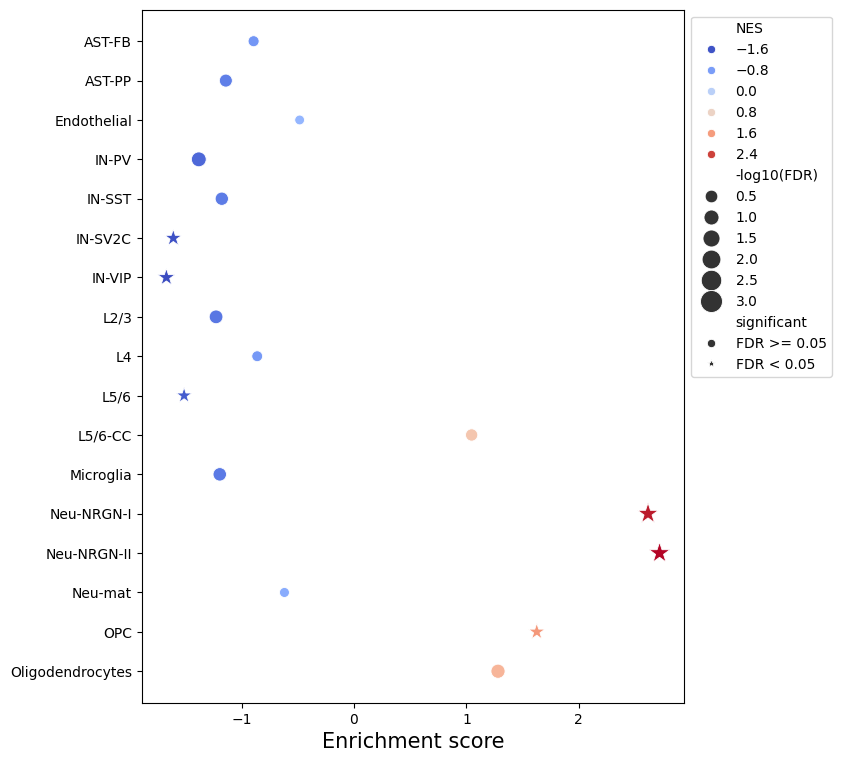

In [17]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

utils.enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [18]:
key = 'wilcoxon'

Run enrichment for genesets

In [19]:
enrich_df = utils.enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2025-06-11 22:14:27,013 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:28,325 [WARNING] Duplicated values found in preranked stats: 0.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:29,378 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:30,442 [WARNING] Duplicated values found in preranked stats: 0.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:31,677 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:32,755 [WARNING] Duplicated values found in preranked stats: 0.20% of genes
The order of those genes will be

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype
0,prerank,human-specific genes,0.329799,0.881076,0.636364,0.636364,0.056,3/23,8.49%,AMZ2;DCXR;CHST10,AST-FB
0,prerank,human-specific genes,-0.305414,-0.616527,0.961136,0.961136,0.961136,11/23,28.24%,GNAZ;SULF2;DLGAP4;GDE1;RGS2;KLHL2;TMED3;OLA1;P...,AST-PP


Process enrichment results

In [20]:
utils.process_enrichment_df(enrich_df)
enrich_df.head(2)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype,-log10(FDR),direction,significant
0,prerank,human-specific genes,0.329799,0.881076,0.636364,0.636364,0.056,3/23,8.49%,AMZ2;DCXR;CHST10,AST-FB,0.195613,enriched,FDR >= 0.05
0,prerank,human-specific genes,-0.305414,-0.616527,0.961136,0.961136,0.961136,11/23,28.24%,GNAZ;SULF2;DLGAP4;GDE1;RGS2;KLHL2;TMED3;OLA1;P...,AST-PP,0.016764,depleted,FDR >= 0.05


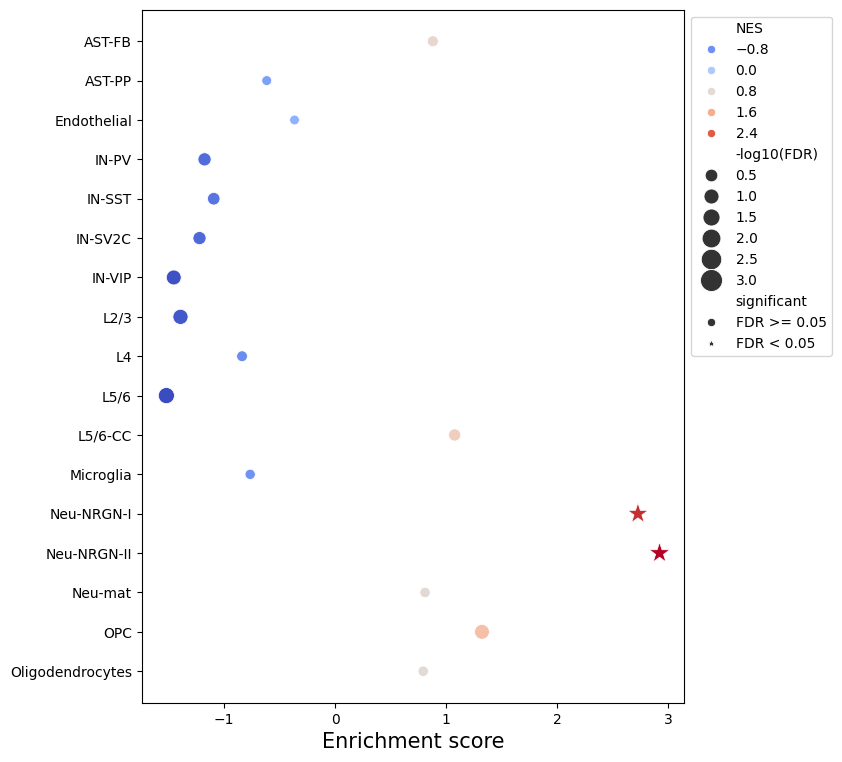

In [21]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

utils.enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [22]:
key = 'logreg'

Run enrichment for genesets

In [23]:
enrich_df = utils.enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2025-06-11 22:14:47,309 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:48,355 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:49,339 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:50,241 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:51,279 [WARNING] Duplicated values found in preranked stats: 0.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:14:53,314 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype
0,prerank,human-specific genes,0.308607,0.788628,0.775748,0.775748,0.467,6/23,13.61%,DCXR;AMZ2;MRPL51;UBA1;CHST10;TMED3,AST-FB
0,prerank,human-specific genes,-0.401069,-1.003352,0.457249,0.457249,0.457249,7/23,13.49%,DLGAP4;MRPL51;TMED3;UBA1;PTPRK;DCXR;OLA1,AST-PP


Process enrichment results

In [24]:
utils.process_enrichment_df(enrich_df)
enrich_df.head(2)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype,-log10(FDR),direction,significant
0,prerank,human-specific genes,0.308607,0.788628,0.775748,0.775748,0.467,6/23,13.61%,DCXR;AMZ2;MRPL51;UBA1;CHST10;TMED3,AST-FB,0.109720,enriched,FDR >= 0.05
0,prerank,human-specific genes,-0.401069,-1.003352,0.457249,0.457249,0.457249,7/23,13.49%,DLGAP4;MRPL51;TMED3;UBA1;PTPRK;DCXR;OLA1,AST-PP,0.338898,depleted,FDR >= 0.05


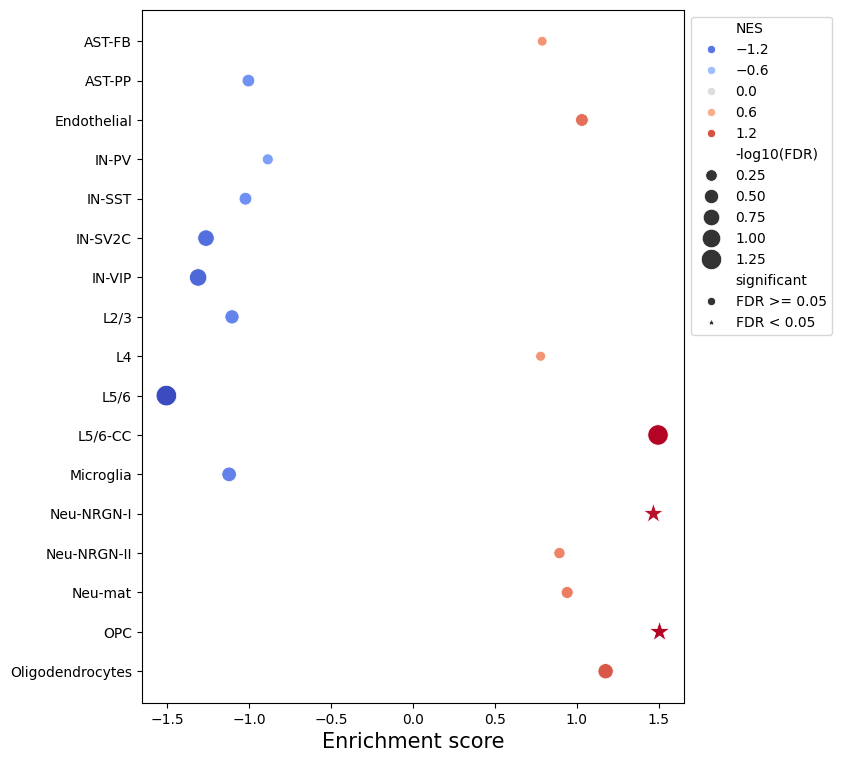

In [25]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

utils.enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [26]:
enrich_df = utils.enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True, 'weight': 0.5})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2025-06-11 22:15:04,532 [WARNING] Duplicated values found in preranked stats: 0.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:15:04,533 [INFO] Parsing data files for GSEA.............................
2025-06-11 22:15:04,546 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2025-06-11 22:15:04,546 [INFO] 0001 gene_sets used for further statistical testing.....
2025-06-11 22:15:04,547 [INFO] Start to run GSEA...Might take a while..................
2025-06-11 22:15:05,413 [INFO] Congratulations. GSEApy runs successfully................

2025-06-11 22:15:05,431 [WARNING] Duplicated values found in preranked stats: 0.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-11 22:15:05,431 [INFO] Parsing data files for GSEA.............................
2025-06-11 22:15:05,442 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype
0,prerank,human-specific genes,0.308229,0.762194,0.793673,0.793673,0.577,3/23,6.30%,AMZ2;SCD5;DCXR,AST-FB
0,prerank,human-specific genes,0.309936,0.698266,0.848485,0.848485,0.7,4/23,15.77%,AMZ2;SCD5;DCXR;CHST10,AST-PP


Process enrichment results

In [27]:
utils.process_enrichment_df(enrich_df)
enrich_df.head(2)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype,-log10(FDR),direction,significant
0,prerank,human-specific genes,0.308229,0.762194,0.793673,0.793673,0.577,3/23,6.30%,AMZ2;SCD5;DCXR,AST-FB,0.099812,enriched,FDR >= 0.05
0,prerank,human-specific genes,0.309936,0.698266,0.848485,0.848485,0.7,4/23,15.77%,AMZ2;SCD5;DCXR;CHST10,AST-PP,0.070844,enriched,FDR >= 0.05


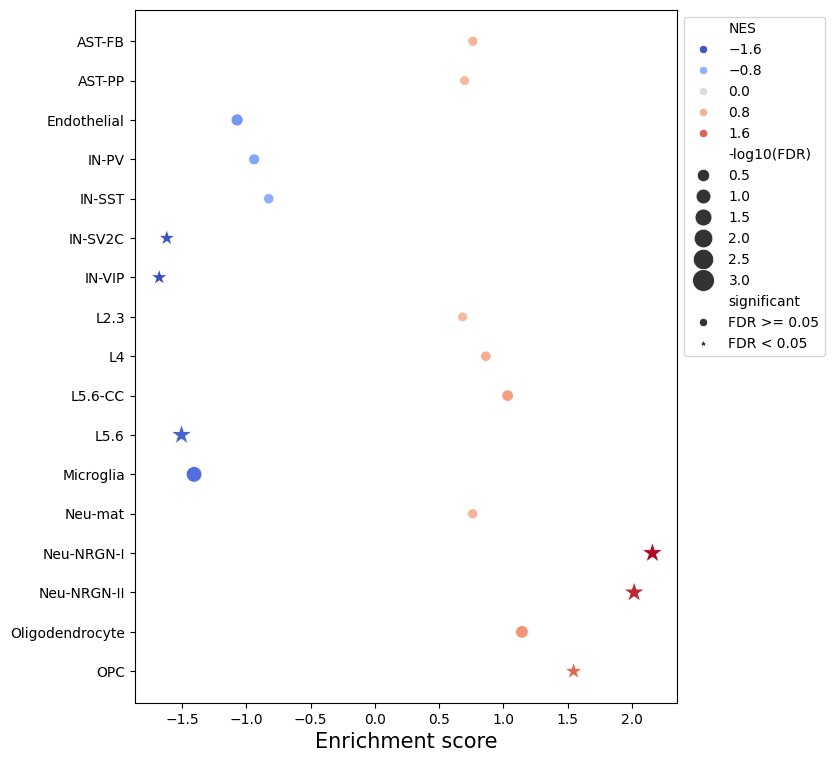

In [28]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)
enrich_norm = mpl.colors.TwoSlopeNorm(vcenter=0)

utils.enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

plt.savefig(f'{figures_dir}/celltype_enrichment.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/celltype_enrichment.pdf', bbox_inches='tight')
plt.show()

### Gene visualization

Calculate average normalized expression

In [29]:
genes = scaled_adata.var_names.intersection(human_specific_genes)
scaled_adata.obs[f'All HS genes'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head(3)

,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),RNA Integrity Number,genes,UMIs,RNA mitochondr. percent,RNA ribosomal percent,All HS genes
cell,,,,,,,,,,,,,,,,
AAACCTGAGATGGCGT-1_4341_BA46,AST-PP,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,7.2,792,1121,0.089206,1.338091,-0.240656
AAACCTGAGCTAACTC-1_4341_BA46,Oligodendrocytes,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,7.2,658,928,0.431034,0.862069,-0.117287
AAACCTGAGTGTTAGA-1_4341_BA46,L5/6,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,7.2,4890,13640,0.857771,0.469208,0.018175


In [30]:
scaled_adata

AnnData object with n_obs × n_vars = 30147 × 23
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent', 'All HS genes'
    var: 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_tsne'

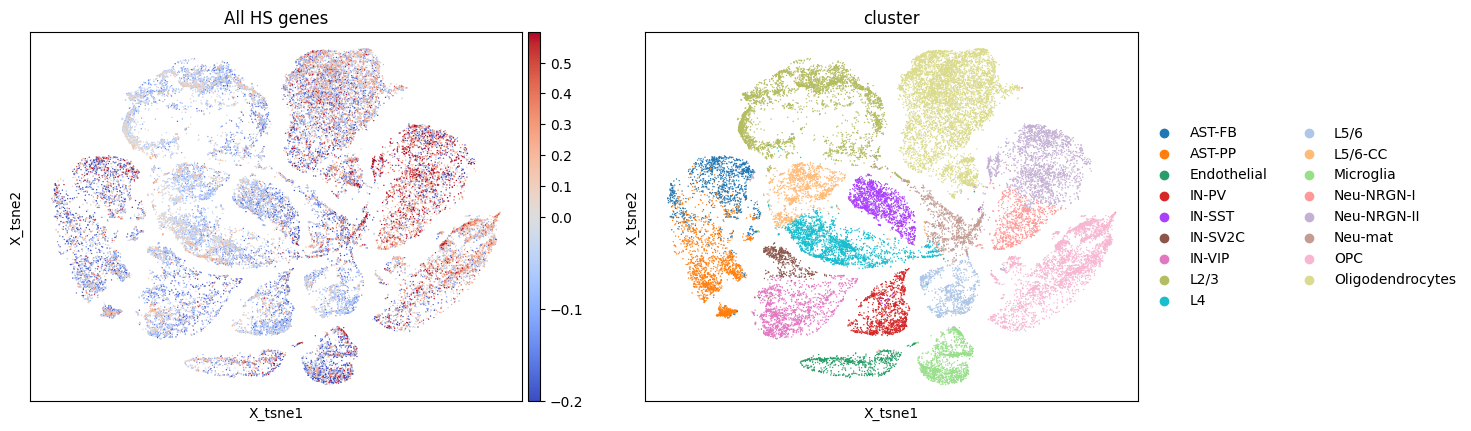

In [32]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.6, vmin=-0.2)

sc.pl.embedding(scaled_adata, basis="X_tsne", color=['All HS genes', 'cluster'], cmap=cmap, norm=norm, show=False)
plt.savefig(f'{figures_dir}/celltype_enrichment_umap.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/celltype_enrichment_umap.pdf', bbox_inches='tight')
plt.show()

In [33]:
gene_sets = dict()
for label in cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = cluster_groups[cluster_groups.label == label].index.to_list()

Calculate average normalized expression

In [34]:
for cluster in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cluster])
    scaled_adata.obs[f'{cluster}'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),...,UMIs,RNA mitochondr. percent,RNA ribosomal percent,All HS genes,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
cell,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGGCGT-1_4341_BA46,AST-PP,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,...,1121,0.089206,1.338091,-0.240656,-0.137119,-0.186891,-0.278627,-0.155660,-0.294831,-0.313874
AAACCTGAGCTAACTC-1_4341_BA46,Oligodendrocytes,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,...,928,0.431034,0.862069,-0.117287,-0.137119,-0.186891,-0.278627,0.553712,-0.294831,-0.313874
AAACCTGAGTGTTAGA-1_4341_BA46,L5/6,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,...,13640,0.857771,0.469208,0.018175,0.239114,0.387020,0.027636,-0.304043,0.153435,-0.072260
AAACCTGCACCCATTC-1_4341_BA46,L2/3,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,...,8526,0.469153,0.516069,-0.103167,0.139986,-0.186891,-0.084802,-0.316561,-0.294831,0.006479
AAACCTGTCTCATTCA-1_4341_BA46,Microglia,4341_BA46,4341,PFC,13,M,Control,CB6,SB2,16,...,846,0.236407,0.945627,-0.293126,-0.137119,-0.186891,-0.278627,-0.457365,-0.294831,-0.313874


Vusualize

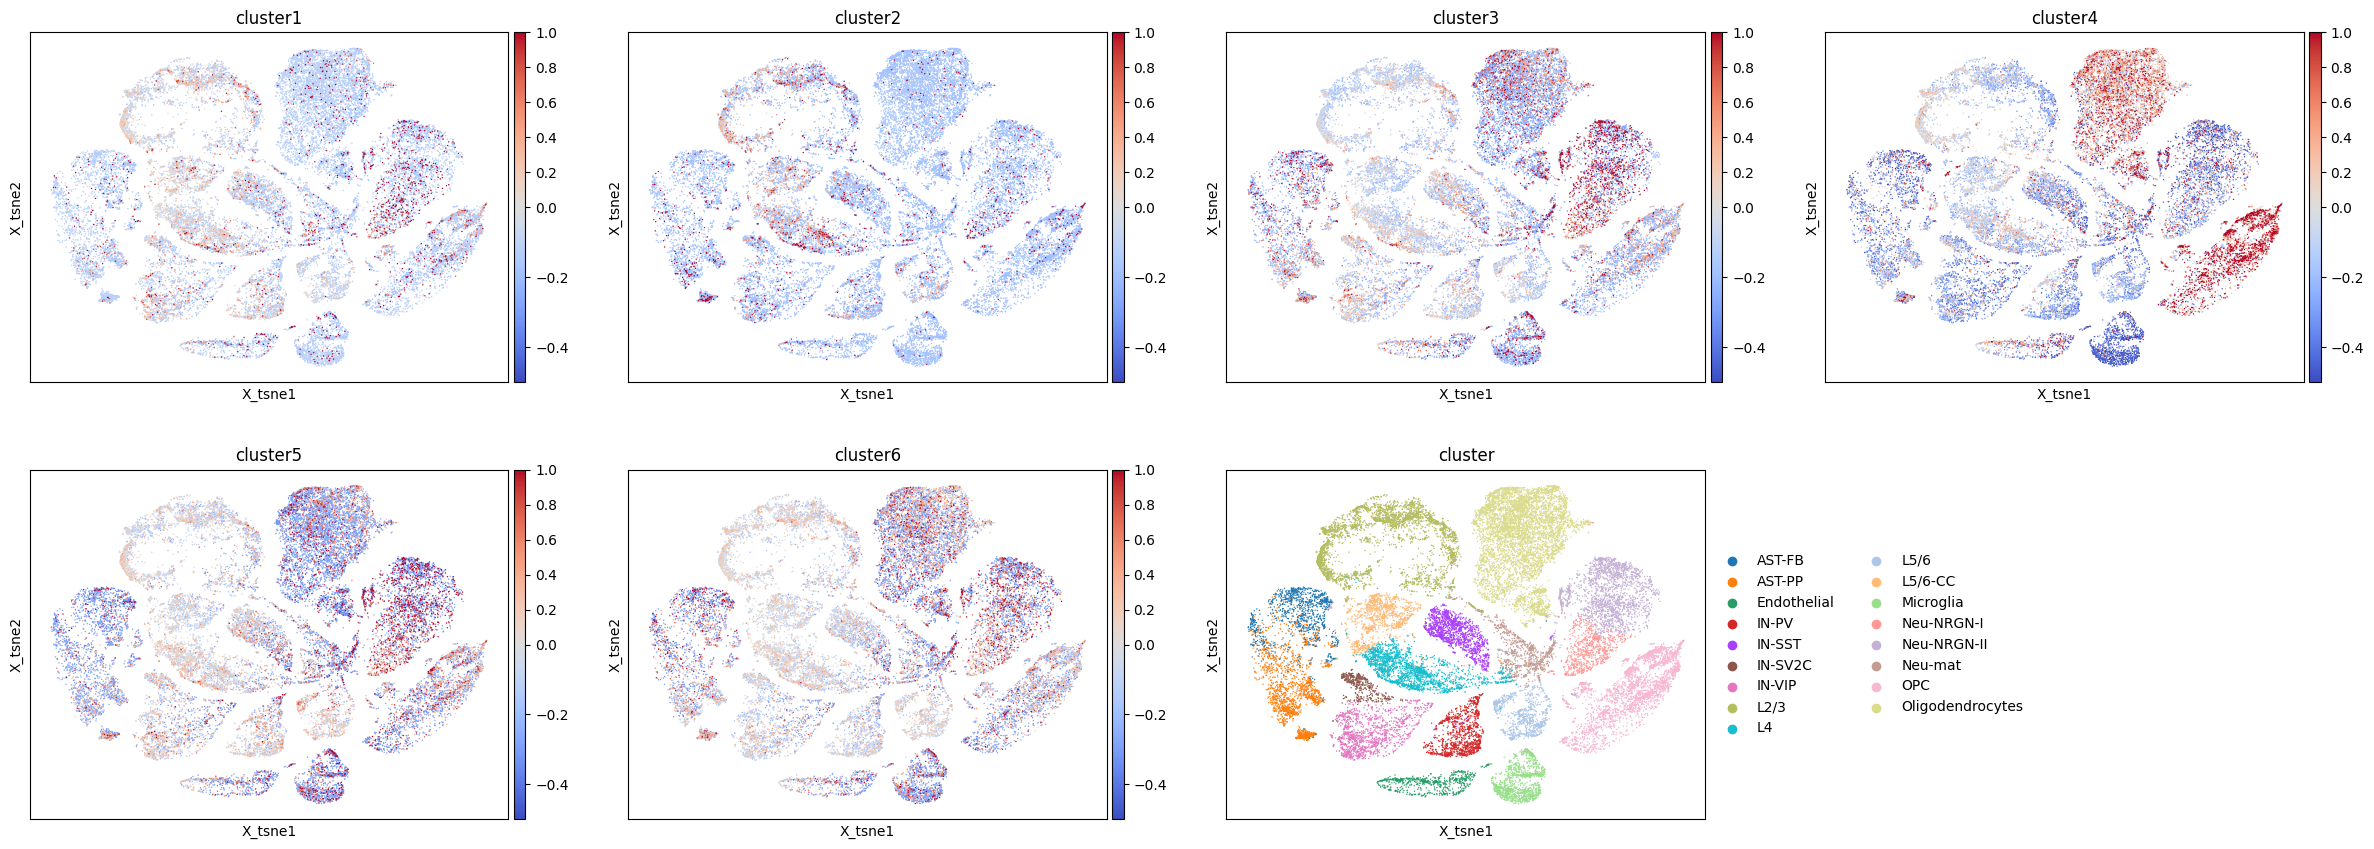

In [35]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1, vmin=-0.5)
color = [
    'cluster1', 
    'cluster2',
    'cluster3', 
    'cluster4', 
    'cluster5',
    'cluster6', 
    'cluster'
    ]

sc.pl.embedding(scaled_adata, basis="X_tsne", color=color, cmap=cmap, norm=norm, ncols=4, show=False)
plt.savefig(f'{figures_dir}/cluster_celltype_enrichment_umap.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/cluster_celltype_enrichment_umap.pdf', bbox_inches='tight')
plt.show()

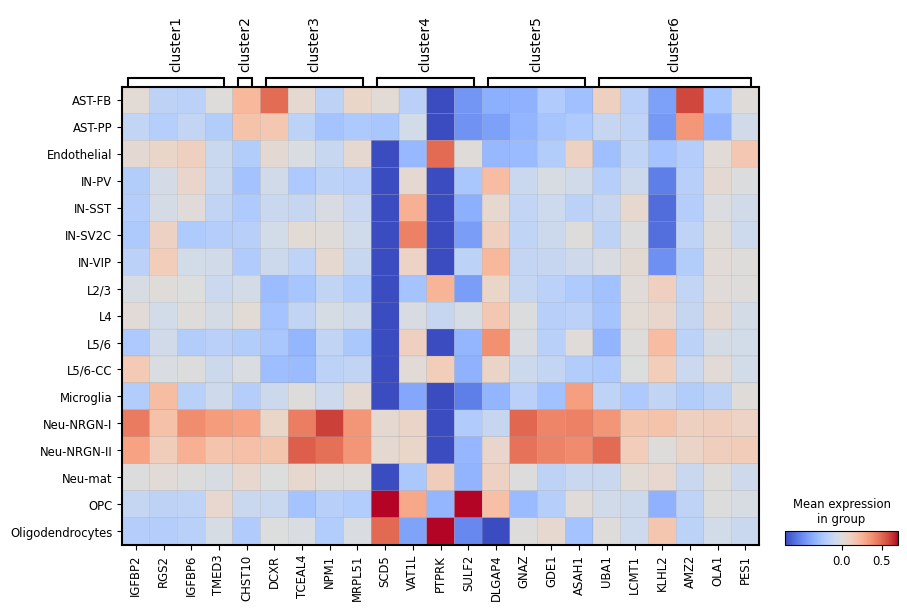

In [36]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.7, vmin=-0.3)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

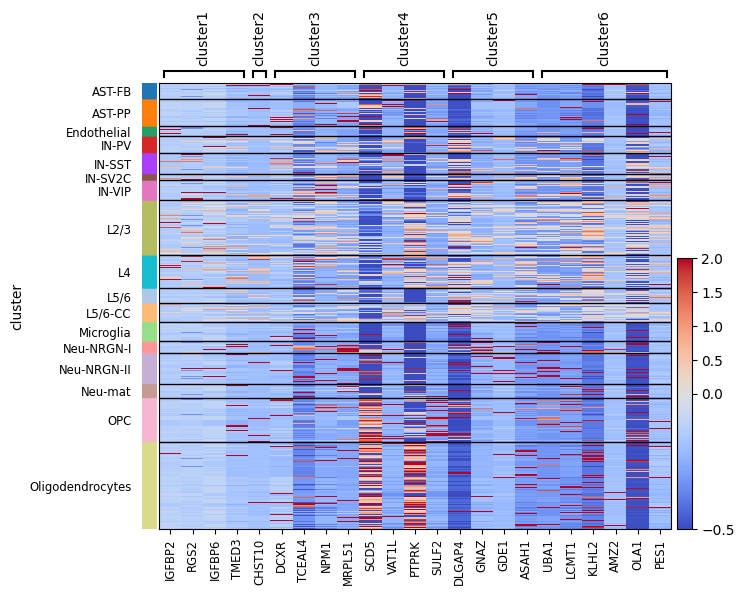

In [37]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-0.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

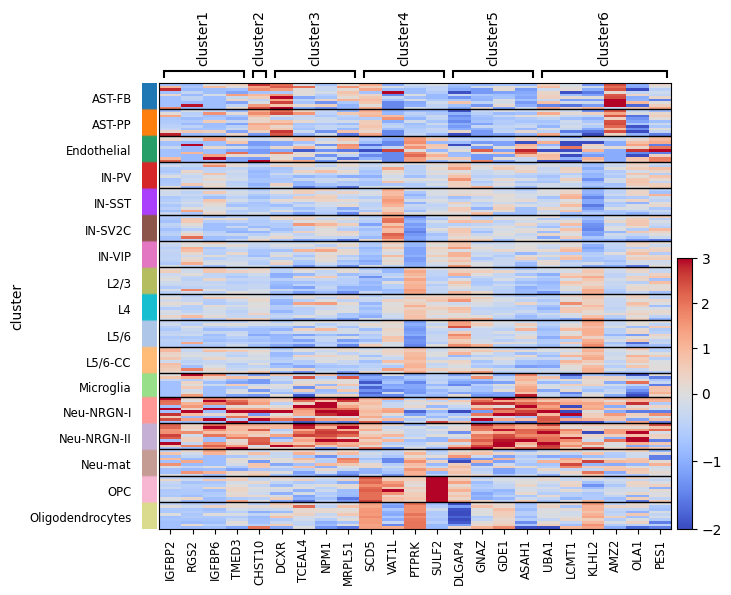

In [38]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-2, vmax=3, show=False)
plt.savefig(f'{figures_dir}/cluster_celltype_enrichment_pb_heatmap.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/cluster_celltype_enrichment_pb_heatmap.pdf', bbox_inches='tight')
plt.show()